#Required libraries

In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Reading log file

In [ ]:
# Define a function to parse the log line
def parse_log_line(line):
    pattern = (
        r",(\d+)"  # Time: milliseconds after the comma
        r".*?ECU's name: ([\w]+)" # ECU's name: word before 's
        r".*?TEC value: (\d+)"  # TEC value: digits
        r".*?Passive error state: (\w+)"  # Passive error state: True/False
        r".*?Bus-off state: (\w+)"  # Bus-off state: True/False
    )
    match = re.search(pattern, line)
    if match:
        return {
            "Time": match.group(1),
            "ECU's Name": match.group(2),
            "TEC Value": match.group(3),
            "Passive Error State": match.group(4),
            "Bus-off State": match.group(5),
        }
    return None

In [ ]:
log_file_path = 'attack_log_one_atk.log'
df = pd.DataFrame()

# Open and read the file
with open(log_file_path, 'r') as log_file:
    for line in log_file:
        # Parse the log line
        parsed_data = parse_log_line(line)

        # Convert parsed data to a DataFrame
        if parsed_data:
            df = pd.concat([df, pd.DataFrame([parsed_data])], ignore_index=True)

In [ ]:
df.head()

,Time,ECU's Name,TEC Value,Passive Error State,Bus-off State
0,468,Victim,0,False,False
1,468,Attacker,0,False,False
2,468,Victim,0,False,False
3,468,Victim,0,False,False
4,469,Victim,0,False,False


# Single attack analysis

Convert int values that are str to int

In [ ]:
df['TEC Value'] = df['TEC Value'].astype(int)
df['Time'] = df['Time'].astype(int)

Adjust time values

In [ ]:
df['Time'] = df['Time'] - df['Time'][0]

In [ ]:
victim_data = df[df["ECU's Name"] == "Victim"].copy()
victim_data.reset_index(drop=True, inplace=True)

attacker_data = df[df["ECU's Name"] == "Attacker"].copy()
attacker_data.reset_index(drop=True, inplace=True)

In [ ]:
attacker_data.head()

,Time,ECU's Name,TEC Value,Passive Error State,Bus-off State
0,0,Attacker,0,False,False
1,53,Attacker,8,False,False
2,53,Attacker,16,False,False
3,53,Attacker,24,False,False
4,54,Attacker,32,False,False


In [ ]:
victim_data.head()

,Time,ECU's Name,TEC Value,Passive Error State,Bus-off State
0,0,Victim,0,False,False
1,0,Victim,0,False,False
2,0,Victim,0,False,False
3,1,Victim,0,False,False
4,2,Victim,0,False,False


### Victim and Attacker's TEC during a bus-off attack

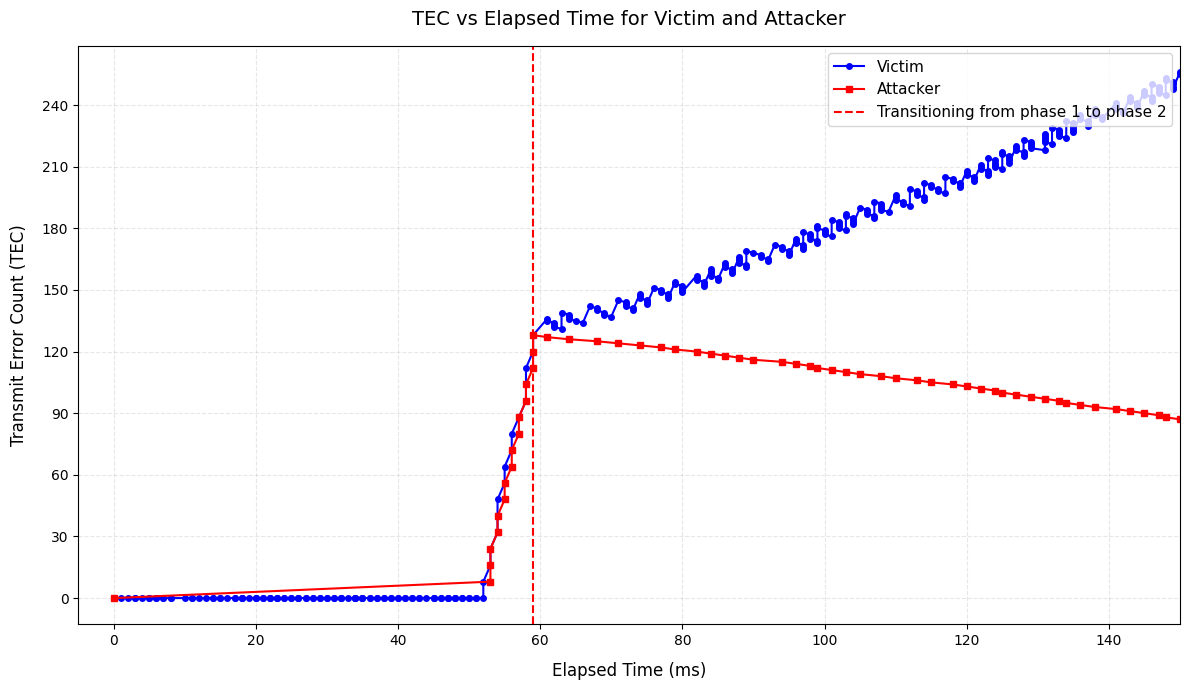

In [ ]:
plt.figure(figsize=(12, 7))

# Plot with connected lines and markers
plt.plot(victim_data["Time"], victim_data["TEC Value"], 'b-o',
         label="Victim", markersize=4, linewidth=1.5)
plt.plot(attacker_data["Time"], attacker_data["TEC Value"], 'r-s',
         label="Attacker", markersize=4, linewidth=1.5)

# Set x-axis ticks to show the actual time range (615-769)
x_ticks = np.arange(0, 150, 20)  # Steps of 20ms
plt.xticks(x_ticks, rotation=0, fontsize=10)

# Set y-axis ticks from 0 to 256
y_ticks = np.arange(0,256,30)  # Steps of 32 for clearer visualization
plt.yticks(y_ticks, rotation=0, fontsize=10)

plt.xlabel("Elapsed Time (ms)", fontsize=12, labelpad=10)
plt.ylabel("Transmit Error Count (TEC)", fontsize=12, labelpad=10)
plt.title("TEC vs Elapsed Time for Victim and Attacker", fontsize=14, pad=15)

# Set axis limits with small padding
plt.xlim(-5, 150)  # Added small padding around the data range

# Improve grid appearance
plt.grid(True, linestyle='--', alpha=0.3)

max_tec_index = attacker_data['TEC Value'].idxmax()
plt.axvline(x=attacker_data['Time'][max_tec_index], color='r', linestyle='--', label='Transitioning from phase 1 to phase 2')

# Improve legend
plt.legend(fontsize=11, loc='upper right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

### Victim's TEC during Phase 1 and 2

First find the index of transition between Phase 1 and Phase 2

In [ ]:
transition_index = victim_data[victim_data["TEC Value"]==128].index[0]

In [ ]:
phase1 = victim_data.loc[:transition_index]
phase2 = victim_data.loc[transition_index:]

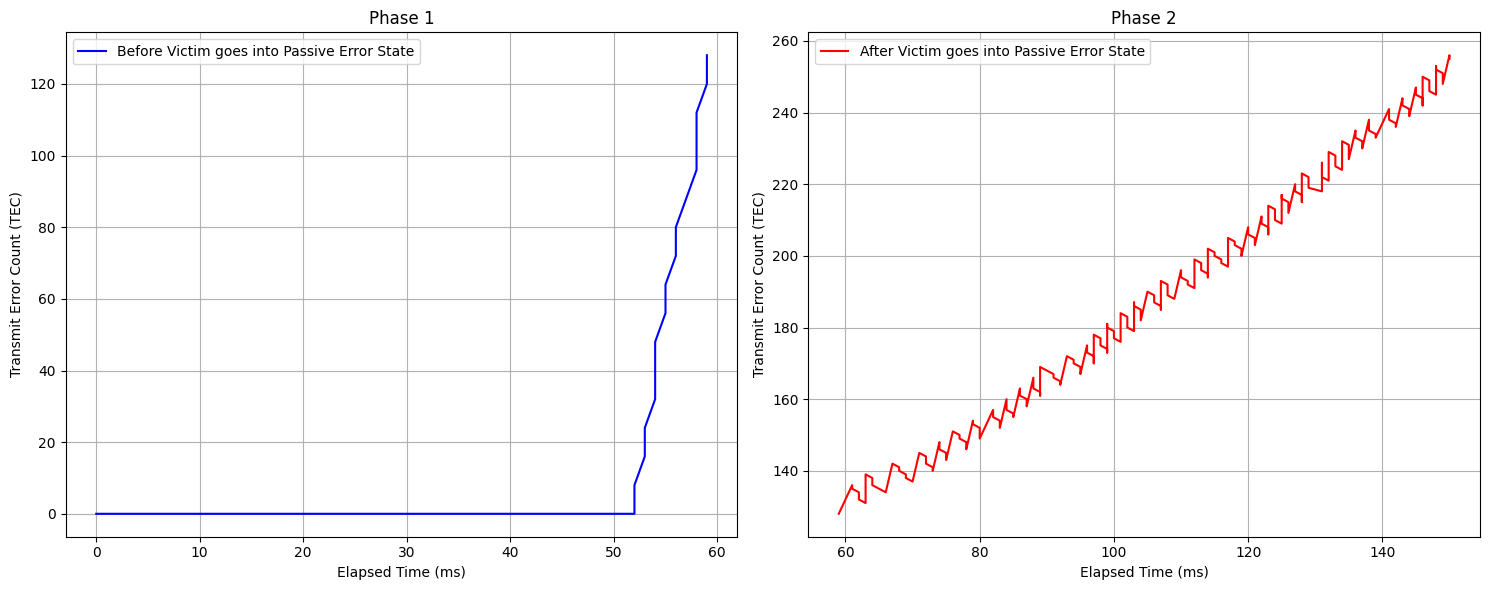

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Plot for Phase 1
axes[0].plot(phase1['Time'], phase1['TEC Value'], label='Before Victim goes into Passive Error State', color='blue')
axes[0].set_xlabel('Elapsed Time (ms)')
axes[0].set_ylabel('Transmit Error Count (TEC)')
axes[0].set_title('Phase 1')
axes[0].legend()
axes[0].grid(True)

# Plot for Phase 2
axes[1].plot(phase2['Time'], phase2['TEC Value'], label='After Victim goes into Passive Error State', color='red')
axes[1].set_xlabel('Elapsed Time (ms)')
axes[1].set_ylabel('Transmit Error Count (TEC)')
axes[1].set_title('Phase 2')
axes[1].legend()
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


# Delays of bus-off attack under different bus speeds




As the authors of the paper we have executed 1000 times the attack varying the bus speeds obtaining the following results.
We have stored the time of which each atk is taking in a vector for each speed varying from 250, 500 and 1000 as in the paper.

### 250Kbps case

In [ ]:
attacks_250 = []

In [ ]:
log_file_path = 'attack_log_250_1katk.log'

In [ ]:
def parse_log_file_to_df(log_file_path):
    attacks_int = []  # List to store DataFrames for each attack
    attacks = []  # Temporary storage for the current attack's value

    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            # Check for the "End of the x-th attack" line
            if "End of the" in line:
                # Store the current attack's times and reset for the next attack
                if attacks:
                    df = pd.DataFrame(attacks)
                    attacks_int.append(df)
                    attacks = []
            else:
                parsed_attack = parse_log_line(line)
                if parsed_attack:
                    attacks.append(parsed_attack)

        # To be sure to have added the last line
        if attacks:
            df = pd.DataFrame(attacks)
            attacks_int.append(df)

    return attacks_int

In [ ]:
attacks_250 = parse_log_file_to_df(log_file_path)

In [ ]:
print(f"Parsed {len(attacks_250)} attacks.")

Parsed 1000 attacks.


Transform str values to int

In [ ]:
def transform_int(attacks_int):
  for df in attacks_int:
    df['Time'] = df['Time'].astype(int)
    df['TEC Value'] = df['TEC Value'].astype(int)

  return attacks_int

In [ ]:
attacks_250 = transform_int(attacks_250)

**Normalization of each time step:**

Since we're working with milliseconds (ms) we have to normalize the values in order to let it start from 0 and consider subsequent numbers after 999. For this latter reason we added 1000 to be able to maintain the monotonic increase of the array.

In [ ]:
def normalize_time(attacks_int):
  for df in attacks_int:
    increase = False
    for i in range(len(df)):
        if increase:
            df.at[i, 'Time'] += 1000

        if i + 1 < len(df):
            # Check if next Time is less than the current Time
            if df.at[i + 1, 'Time'] < df.at[i, 'Time']:
                increase = True
  return attacks_int

In [ ]:
attacks_250 = normalize_time(attacks_250)

In [ ]:
def subtract_baseline(attacks_int):
  for df in attacks_int:
    df['Time'] = df['Time'] - df['Time'][0]

  return attacks_int

In [ ]:
attacks_250 = subtract_baseline(attacks_250)

Now we care just of the last value of each subarray to calculate the delay for the 250Kbps case.

In [ ]:
final_time_250 = []
for attack in attacks_250:
  attack = pd.DataFrame(attack)
  final_time_250.append(attack.iloc[-1]['Time'])

### 500Kbps case

In [ ]:
log_file_path = "attack_log_500_1katk.log"

In [ ]:
attacks_500 = parse_log_file_to_df(log_file_path)

In [ ]:
print(f"Parsed {len(attacks_500)} attacks.")

Parsed 1000 attacks.


In [ ]:
attacks_500 = transform_int(attacks_500)

In [ ]:
attacks_500 = normalize_time(attacks_500)

In [ ]:
attacks_500 = subtract_baseline(attacks_500)

In [ ]:
final_time_500 = []
for attack in attacks_500:
  attack = pd.DataFrame(attack)
  final_time_500.append(attack.iloc[-1]['Time'])

### 1000Kbps case

In [ ]:
log_file_path = "attack_log_1000_1katk.log"

In [ ]:
attacks_1000 = parse_log_file_to_df(log_file_path)

In [ ]:
print(f"Parsed {len(attacks_1000)} attacks.")

Parsed 1000 attacks.


In [ ]:
attacks_1000 = transform_int(attacks_1000)

In [ ]:
attacks_1000 = normalize_time(attacks_1000)

In [ ]:
attacks_1000 = subtract_baseline(attacks_1000)

Analyzing this case using 1000Kbps we noticed that some attacks:
*   Victim did **not go** in **error-passive mode**
*   Victim **went in error-passive mode** and did **not go in bus-off state**
*   Victim **went in error-passive mode** and **went in bus-off state**





In [ ]:
error_passive = 0
error_passive_nobusoff = 0

In [ ]:
for attack in attacks_1000:
  attack = pd.DataFrame(attack)
  if attack.iloc[-1]['Passive Error State'] == 'True' and attack.iloc[-1]['ECU\'s Name'] == 'Victim':
    error_passive += 1
    if attack.iloc[-1]['Bus-off State'] == 'False':
      error_passive_nobusoff += 1

In [ ]:
no_error_passive = 1000-error_passive
print(f"Number of attacks were the Victim did not reach error-passive mode: {no_error_passive}")

Number of attacks were the Victim did not reach error-passive mode: 17


In [ ]:
print(f"Number of attacks were the Victim went in error-passive mode but did not go in bus-off state: {error_passive_nobusoff}")

Number of attacks were the Victim went in error-passive mode but did not go in bus-off state: 1


### Final comparison between the cases

In the following blox plots we can notice the comparison between different bus speeds of:
*   Error-passive
*   Bus-off



In [ ]:
time_error_passive_1000 = []
time_error_passive_500 = []
time_error_passive_250 = []

In [ ]:
def time_passive_error_state(attacks_int,time_error_passive):
  for attack in attacks_int:
    attack = pd.DataFrame(attack)
    for i in range(len(attack)):
      if attack.iloc[i]['Passive Error State'] == 'True':
        time = attack.iloc[i]['Time']
        time_error_passive.append(time)
        break

In [ ]:
time_passive_error_state(attacks_1000,time_error_passive_1000)

In [ ]:
time_passive_error_state(attacks_500,time_error_passive_500)

In [ ]:
time_passive_error_state(attacks_250,time_error_passive_250)

In [ ]:
data_250 = pd.DataFrame({'CAN bus speed': ['250Kbps'] * len(time_error_passive_250), 'Delay (ms)': time_error_passive_250})
data_500 = pd.DataFrame({'CAN bus speed': ['500Kbps'] * len(time_error_passive_500), 'Delay (ms)': time_error_passive_500})
data_1000 = pd.DataFrame({'CAN bus speed': ['1000Kbps'] * len(time_error_passive_1000), 'Delay (ms)': time_error_passive_1000})

combined_data = pd.concat([data_250, data_500, data_1000], ignore_index=True)

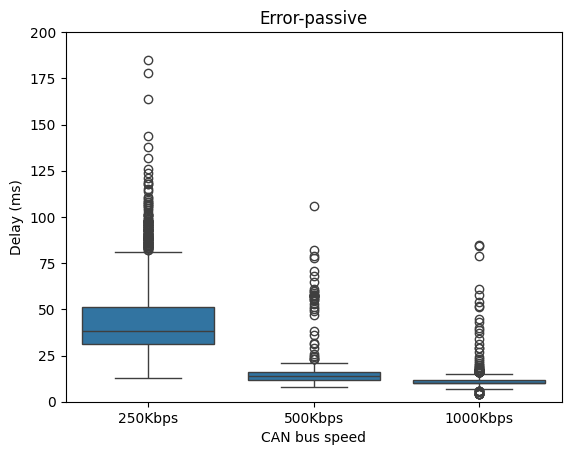

In [ ]:
# Plot the combined data
sns.boxplot(x='CAN bus speed', y='Delay (ms)', data=combined_data)

# Add labels and title
plt.title('Error-passive')
plt.xlabel('CAN bus speed')
plt.ylabel('Delay (ms)')

plt.ylim(0, 200)

# Show the plot
plt.show()

So far the attacks changing the bus speed were 100% successful, however we have noticed that few attacks were not successful using this speed, so we will take them off. To complete the comparison, since the failed attacks were just a few, we decided to take them out.

In [ ]:
failed_atks = 0

In [ ]:
for i in range(len(attacks_1000) - 1, -1, -1):  # Iterate from the last element to the first
    attack = pd.DataFrame(attacks_1000[i])
    if attack.iloc[-1]['Bus-off State'] == 'False':
        failed_atks += 1
        del attacks_1000[i]

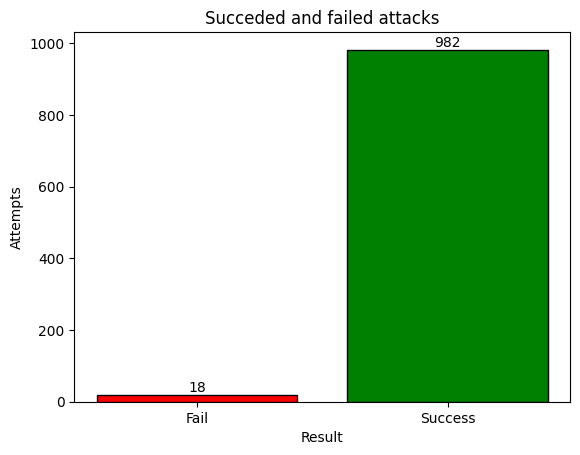

In [ ]:
categories = ['Fail', 'Success']
counts = [failed_atks, len(attacks_1000)]

plt.bar(categories, counts, color=['red', 'green'], edgecolor='black')

for i, count in enumerate(counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Result')
plt.ylabel('Attempts')
plt.title('Succeded and failed attacks')
plt.show()

In [ ]:
final_time_1000 = []
for attack in attacks_1000:
  attack = pd.DataFrame(attack)
  final_time_1000.append(attack.iloc[-1]['Time'])

In [ ]:
data_250 = pd.DataFrame({'CAN bus speed': ['250Kbps'] * len(final_time_250), 'Delay (ms)': final_time_250})
data_500 = pd.DataFrame({'CAN bus speed': ['500Kbps'] * len(final_time_500), 'Delay (ms)': final_time_500})
data_1000 = pd.DataFrame({'CAN bus speed': ['1000Kbps'] * len(final_time_1000), 'Delay (ms)': final_time_1000})

combined_data = pd.concat([data_250, data_500, data_1000], ignore_index=True)

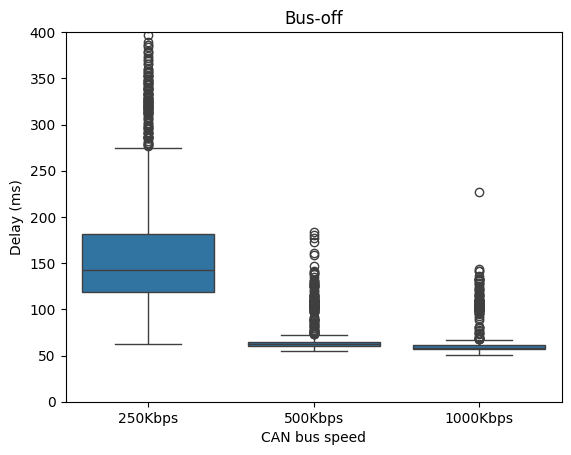

In [ ]:
# Plot the combined data
sns.boxplot(x='CAN bus speed', y='Delay (ms)', data=combined_data)

# Add labels and title
plt.title('Bus-off')
plt.xlabel('CAN bus speed')
plt.ylabel('Delay (ms)')

plt.ylim(0, 400)

# Show the plot
plt.show()